In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# ACF
from statsmodels.graphics.tsaplots import plot_acf

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Now, all expressions in a cell will be outputted, not just the last one.


In [2]:
# Read data
stock_df = pd.read_csv("./individual_book_train/stock_1.csv")

stock_df.info()
stock_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507532 entries, 0 to 1507531
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   time_id            1507532 non-null  int64  
 1   seconds_in_bucket  1507532 non-null  int64  
 2   bid_price1         1507532 non-null  float64
 3   ask_price1         1507532 non-null  float64
 4   bid_price2         1507532 non-null  float64
 5   ask_price2         1507532 non-null  float64
 6   bid_size1          1507532 non-null  int64  
 7   ask_size1          1507532 non-null  int64  
 8   bid_size2          1507532 non-null  int64  
 9   ask_size2          1507532 non-null  int64  
 10  stock_id           1507532 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 126.5 MB


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100,1
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100,1
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125,1
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36,1
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25,1


In [3]:
# Data cleaning
df_grouped = stock_df.groupby('time_id')

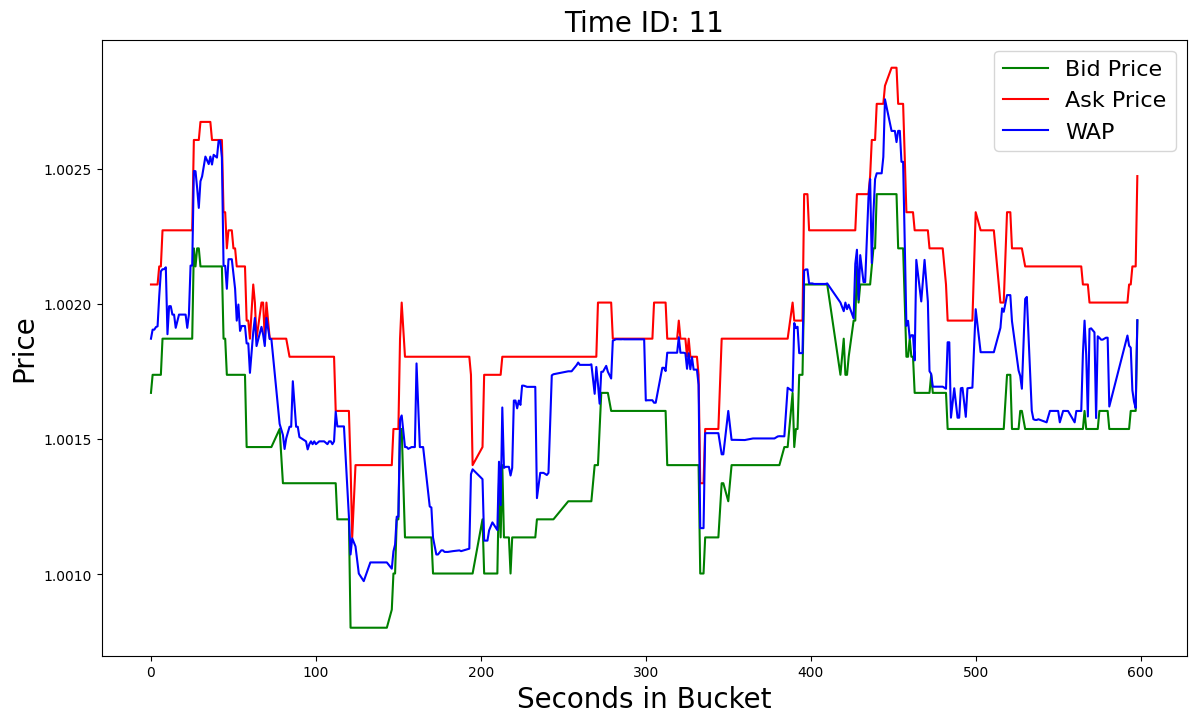

In [4]:
# Calculate WAP
def calculate_wap(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy['WAP'] = (df_copy['bid_price1']*df_copy['ask_size1'] + df_copy['ask_price1']*df_copy['bid_size1']) /\
    (df_copy['bid_size1'] + df_copy['ask_size1'])
    return df_copy


# Visualization on bid-ask price
def visualize_price_in_time_id(time_id: int):
    df = calculate_wap(df_grouped.get_group(time_id))

    plt.figure(figsize=(14,8))
    sns.lineplot(data=df, x='seconds_in_bucket', y='bid_price1', color='green', label='Bid Price')
    sns.lineplot(data=df, x='seconds_in_bucket', y='ask_price1', color='red', label='Ask Price')
    sns.lineplot(data=df, x='seconds_in_bucket', y='WAP', color='blue', label='WAP')

    plt.title(f"Time ID: {time_id}", fontsize=20)
    plt.xlabel('Seconds in Bucket', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.legend(loc='upper right', fontsize=16)
    
    plt.show()

# Applied Function
visualize_price_in_time_id(11)

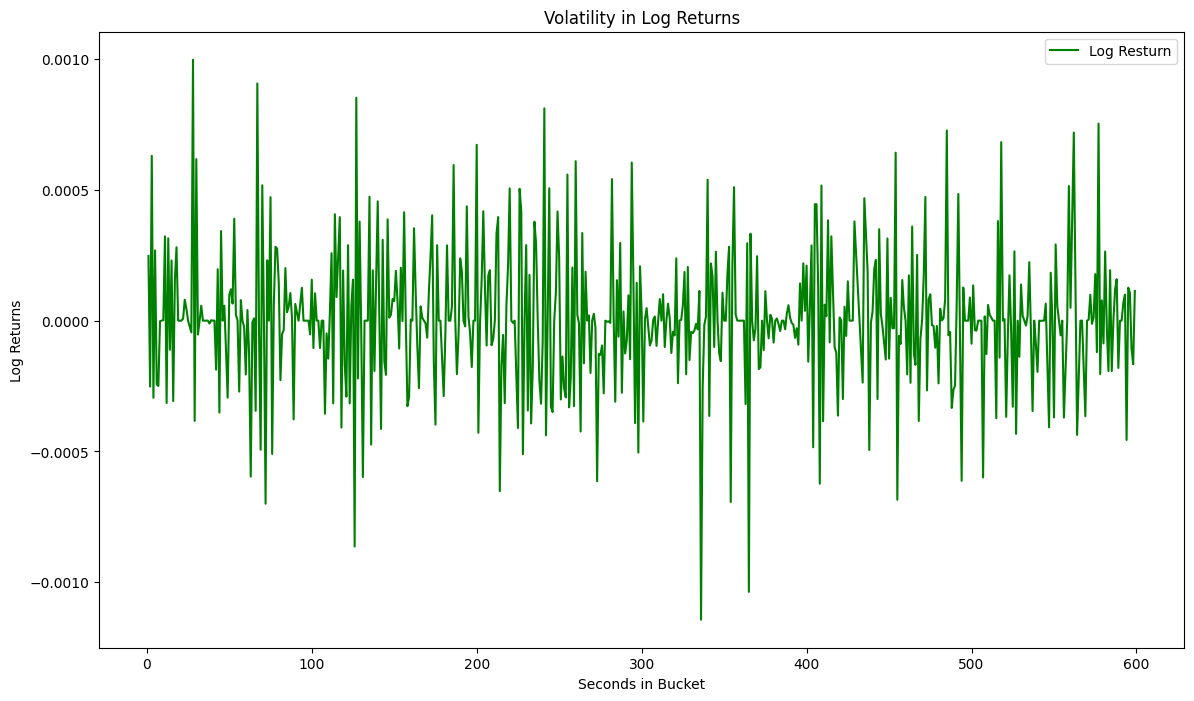

In [5]:
def calculate_log_returns(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    if 'WAP' not in df_copy.columns:
        df_copy = calculate_wap(df_copy)
    
    df_copy['log_return'] = np.log(df_copy['WAP'] / df_copy['WAP'].shift(1))
    
    return df_copy

def visualize_log_returns_in_time_id(time_id: int):
    df = calculate_log_returns(df_grouped.get_group(time_id))

    plt.figure(figsize=(14,8))
    sns.lineplot(data=df, x='seconds_in_bucket', y='log_return', color='green', label='Log Resturn')

    plt.ylabel('Log Returns')
    plt.xlabel('Seconds in Bucket')
    plt.title('Volatility in Log Returns')

    plt.show

# Applied Function
visualize_log_returns_in_time_id(5)

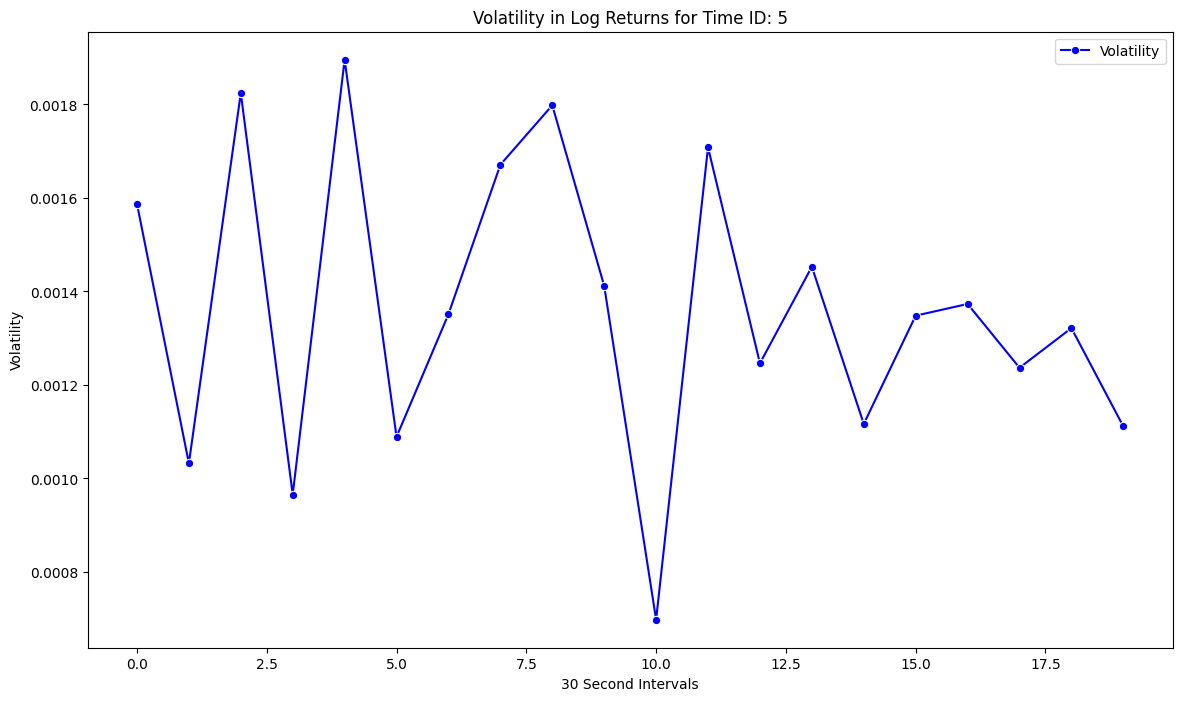

In [6]:
def calculate_volatility(df: pd.DataFrame, window_size: int) -> pd.DataFrame:
    df_copy = df.copy()
    if 'log_return' not in df_copy.columns:
        df_copy = calculate_log_returns(df_copy)
    interval_name = f'interval_in_{window_size}'
    df_copy[interval_name] = df_copy['seconds_in_bucket'] // window_size
    df_copy_grouped = df_copy.groupby(interval_name)
    volatility = df_copy_grouped['log_return'].apply(lambda x: np.sqrt(np.sum(x**2))).reset_index()
    
    volatility.rename(columns={'log_return': 'volatility'}, inplace=True)

    return volatility
    
def visualize_volatility_in_time_id(time_id: int):
    df = calculate_log_returns(df_grouped.get_group(time_id))
    interval_length = 30
    volatility = calculate_volatility(df, interval_length)

    plt.figure(figsize=(14, 8))
    sns.lineplot(data=volatility, x=f'interval_in_{interval_length}', y='volatility', marker='o', color='blue', label='Volatility')
    
    plt.ylabel('Volatility')
    plt.xlabel(f'{interval_length} Second Intervals')
    plt.title(f'Volatility in Log Returns for Time ID: {time_id}')
    plt.legend()
    plt.show()

visualize_volatility_in_time_id(5)


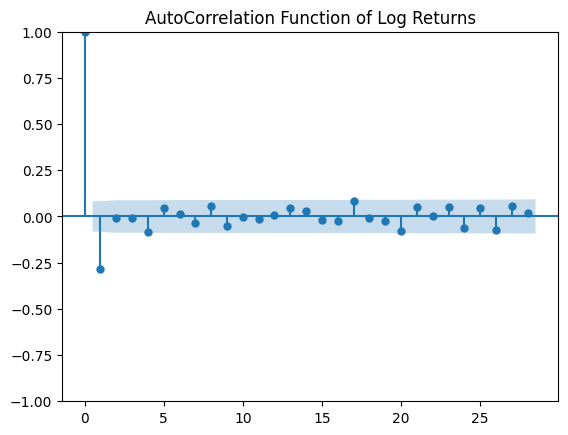

In [7]:
# ACF for log
def visualize_ACF(time_id: int):
    df = calculate_log_returns(df_grouped.get_group(time_id))

    plot_acf(df['log_return'].dropna(), alpha=0.05)
    plt.title('AutoCorrelation Function of Log Returns')
    plt.show()

visualize_ACF(5)

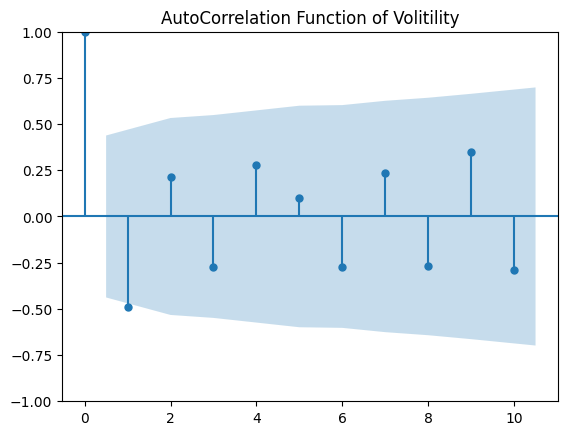

In [8]:
# visualize ACF for volitility
def visualize_ACF_volitility(time_id: int):
    df = calculate_volatility(df_grouped.get_group(time_id), 30)
    plot_acf(df['volatility'], alpha=0.05)
    plt.title('AutoCorrelation Function of Volitility')
    plt.show()

visualize_ACF_volitility(5)

## GARCH Model Fitting and Assessing

Applying GARCH model for time_id=5 in Stock_1, using training data from 0 to 480 seconds.

In [9]:
from arch import arch_model

# Interpolation function for training models
def interpolute_log_returns(df: pd.DataFrame) -> pd.DataFrame:
    full_seconds = pd.DataFrame({'seconds_in_bucket': range(600)})
    
    merged_df = pd.merge(full_seconds, df, on='seconds_in_bucket', how='left')
    merged_df['log_return'] = merged_df['log_return'].fillna(0)
    return merged_df


# GARCH for time_id = 5
df_5 = df_grouped.get_group(5)
df_5 = calculate_log_returns(df_5).dropna()
df_5 = interpolute_log_returns(df_5)

train_X = df_5.loc[df_5['seconds_in_bucket']<480, 'log_return']
y = df_5.loc[df_5['seconds_in_bucket']>=480, 'log_return']
# Rescaling data for better performance
train_X_scaled = train_X * 1e+04
model = arch_model(train_X_scaled, mean='Zero', vol='ARCH', p=1, q=1)
arch = model.fit()
forecasts = arch.forecast(horizon=120, method='simulation', simulations=100)

Iteration:      1,   Func. Count:      4,   Neg. LLF: 1161.2721781077928
Iteration:      2,   Func. Count:      9,   Neg. LLF: 1135.7253295733221
Iteration:      3,   Func. Count:     13,   Neg. LLF: 1135.709192161818
Iteration:      4,   Func. Count:     15,   Neg. LLF: 1135.7091921616234
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1135.709192161818
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4


Visulization for the predictions

<Figure size 1200x600 with 0 Axes>

<Axes: >

<Axes: ylabel='log_return'>

Text(0.5, 1.0, 'ARCH Model Forecasts vs Actual Returns (Seconds 480 to 600)')

Text(0.5, 0, 'Seconds in Bucket')

Text(0, 0.5, 'Log Returns')

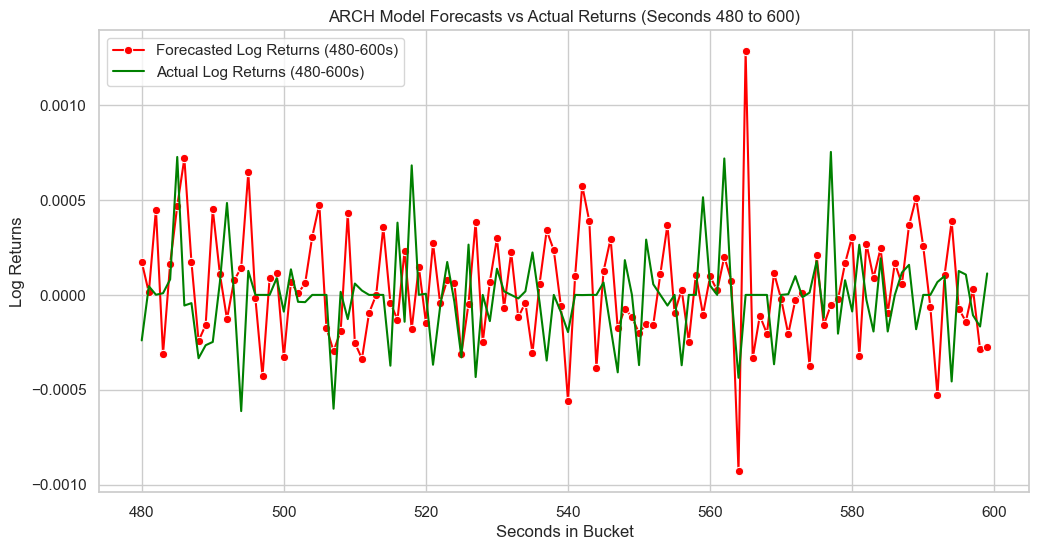

In [10]:
# Visulization
simulated_paths = forecasts.simulations.values[:, 0, :].T  # This gets the forecast paths

# Calculate the mean and percentiles of the simulated paths
mean_forecast = np.mean(simulated_paths, axis=1)
percentile_5 = np.percentile(simulated_paths, 5, axis=1)
percentile_95 = np.percentile(simulated_paths, 95, axis=1)

sns.set(style="whitegrid")

mean_forecast /= 1e+04
percentile_5 /= 1e+04
percentile_95 /= 1e+04

historical_index = df_5[df_5['seconds_in_bucket'] >= 480].index
forecast_index = np.arange(480, 600)  # Focusing only on the 480 to 600 seconds interval

plt.figure(figsize=(12, 6))

sns.lineplot(x=forecast_index, y=mean_forecast, label='Forecasted Log Returns (480-600s)', color='red', marker='o', linestyle='-')

actual_values_index = np.arange(480, 600)
sns.lineplot(x=actual_values_index, y=y, label='Actual Log Returns (480-600s)', color='green', linestyle='-')

plt.title('ARCH Model Forecasts vs Actual Returns (Seconds 480 to 600)')
plt.xlabel('Seconds in Bucket')
plt.ylabel('Log Returns')
plt.legend()
plt.show()

Put the model traing in function to allow different prediction time intervals

In [13]:
# GARCH
def GARCH_model(df: pd.DataFrame, prediction_time_period: int):
    df_copy = df.copy()
    df_copy = calculate_log_returns(df_copy)
    df_copy = interpolute_log_returns(df_copy)

    train_X = df_copy.loc[df_copy['seconds_in_bucket']<600-prediction_time_period, 'log_return']
    y = df_copy.loc[df_copy['seconds_in_bucket']>=600-prediction_time_period, 'log_return']
    
    # rescaling
    train_X_scaled = train_X * 1e+04

    model = arch_model(train_X_scaled, mean='Zero', vol='ARCH', p=1, q=1)
    garch_model = model.fit(disp='off')
    forecasts = garch_model.forecast(horizon=prediction_time_period, method='simulation', simulations=100)
    
    return forecasts, y    

Apply the model to the whole stock time_ids and assess the model

In [14]:
from sklearn.metrics import mean_squared_error

mse_results = {}

for group_name, group_df in df_grouped:
    forecast, actual = GARCH_model(group_df, 60)
    forecast_mean = np.mean(forecast.simulations.values[:, 0, :].T, axis=1)
    # add to mse result table
    mse_results[group_name] = mean_squared_error(actual, forecast_mean / 1e+04)
    
mse_df = pd.DataFrame.from_dict(mse_results, orient='index', columns=['MSE'])
mse_df.index.name = 'time_id'
print(mse_df)

ValueError: Found input variables with inconsistent numbers of samples: [120, 60]